## Feature Consolidation and Split

The purpose of this notebook is to consolidate a set of features, perform final null handling (some imputation), and perform a seeded train-test-split for consistency on training and comparing model performance. It also creates a JSON for hyperparameters for the ML model section to use.

- [Conslidation](#consol)
- [Null Handling](#null)
- [Train-Test Split](#split)
    *- standard scaler applied here or in modeling notebook?*
- [Model Parameters JSON](#json)

In [1]:
# assign seed now for consistency any time it needs to be used
seed=27

In [2]:
import pandas as pd
import geopandas as gpd
#import numpy as np
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
import pickle

In [3]:
file_path = "../../data/data_v08_fire_interval.parquet"
df = gpd.read_parquet(file_path)
print('raw data: ',df.shape)
df

raw data:  (1379, 49)


,fire_name,year,fire_id,fire_segid,database,state,response,stormdate,gaugedist_m,stormstart,...,Igneous,Metamorphic,Sedimentary,Unconsolidated,domrt,index_right,LNDS_RISKV,LNDS_RISKS,LNDS_RISKR,fire_interval
0,Buckweed,2007,bck,bck_1035,Training,CA,0,22,1998.67,2008-01-21 16:27:00,...,0.0,1.000000,0.000000,0.0,Metamorphic,205,380675.353544,96.305814,Relatively High,1.0
1,Buckweed,2007,bck,bck_1090,Training,CA,0,22,2368.93,2008-01-21 16:27:00,...,0.0,1.000000,0.000000,0.0,Metamorphic,205,380675.353544,96.305814,Relatively High,1.0
2,Buckweed,2007,bck,bck_1570,Training,CA,0,22,3956.74,2008-01-21 16:27:00,...,0.0,0.973247,0.026753,0.0,Metamorphic,205,380675.353544,96.305814,Relatively High,1.0
3,Buckweed,2007,bck,bck_235,Training,CA,0,22,1734.72,2008-01-21 15:47:00,...,0.0,1.000000,0.000000,0.0,Metamorphic,205,380675.353544,96.305814,Relatively High,1.0
4,Buckweed,2007,bck,bck_363,Training,CA,0,22,1801.04,2008-01-21 15:47:00,...,0.0,1.000000,0.000000,0.0,Metamorphic,205,380675.353544,96.305814,Relatively High,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1545,Wallow,2011,wlw,wlw_47409,Test,AZ,0,7,2706.25,2011-09-07 15:00:00,...,1.0,0.000000,0.000000,0.0,Igneous,102,245876.108811,94.282043,Relatively Moderate,0.0
1546,Wallow,2011,wlw,wlw_47535,Test,AZ,0,11,2891.75,2011-07-11 14:45:00,...,1.0,0.000000,0.000000,0.0,Igneous,102,245876.108811,94.282043,Relatively Moderate,0.0
1547,Wallow,2011,wlw,wlw_47535,Test,AZ,0,26,2891.75,2011-07-26 10:45:00,...,1.0,0.000000,0.000000,0.0,Igneous,102,245876.108811,94.282043,Relatively Moderate,0.0
1548,Wallow,2011,wlw,wlw_47535,Test,AZ,0,15,2891.75,2011-08-15 11:00:00,...,1.0,0.000000,0.000000,0.0,Igneous,102,245876.108811,94.282043,Relatively Moderate,0.0


## Feature Consolidation <a id="consol">

Sedimentary and Unconsolidated rocks have similar debris flow occurrences.

Define additional features:
-  `SedUn`: fraction of watershed covered by sedimentary and unconsolidated rocks.
- `SuscFrac`: fraction of watershed covered by susceptible vegetation types (everything except grassland, `GR`

In [4]:
df["SedUn"] = df["Sedimentary"] + df["Unconsolidated"]
df["SuscFrac"] = df["GS"] + df["SH"] + df["TL"] + df["TU"]

In [5]:
# df.loc[0,:]

In [6]:
use_cols = [
    'SiteID', # will ultimately be needed for joining    
    'fire_id',
    'fire_name',
    'fire_segid',
    'year',
    'state',
    #'database', # original staley train/test
    'response',
    'stormdate',
    'gaugedist_m',
    'lat',
    'lon',
    'geom',
    #'geometry', # this get's lost along the way, need to go back, best to retain this feature so we're not joining later
]

In [7]:
feature_cols = [
    'peak_i15_mmh',
    # 'peak_i30_mmh', 
    # 'peak_i60_mmh', 
    'contributingarea_km2', 
    'prophm23',
    'dnbr1000', 
    'kf', 
    #'acc015_mm', 
    # 'acc030_mm', 
    # 'acc060_mm', 
    'Fine fuel load', 
    'SAV', 
    'Packing ratio', 
    'Extinction moisture content',
    'LNDS_RISKS',
    'fire_interval',
    'SedUn',
    'SuscFrac',
]

In [8]:
use_cols + feature_cols

['SiteID',
 'fire_id',
 'fire_name',
 'fire_segid',
 'year',
 'state',
 'response',
 'stormdate',
 'gaugedist_m',
 'lat',
 'lon',
 'geom',
 'peak_i15_mmh',
 'contributingarea_km2',
 'prophm23',
 'dnbr1000',
 'kf',
 'Fine fuel load',
 'SAV',
 'Packing ratio',
 'Extinction moisture content',
 'LNDS_RISKS',
 'fire_interval',
 'SedUn',
 'SuscFrac']

In [9]:
df = df[use_cols + feature_cols]
df

,SiteID,fire_id,fire_name,fire_segid,year,state,response,stormdate,gaugedist_m,lat,...,dnbr1000,kf,Fine fuel load,SAV,Packing ratio,Extinction moisture content,LNDS_RISKS,fire_interval,SedUn,SuscFrac
0,0,bck,Buckweed,bck_1035,2007,CA,0,22,1998.67,34.542358,...,0.297853,0.250000,1.808258,1818.146903,0.002187,15.000000,96.305814,1.0,0.000000,0.656167
1,1,bck,Buckweed,bck_1090,2007,CA,0,22,2368.93,34.540093,...,0.224896,0.250000,1.384151,1821.989060,0.001839,15.000000,96.305814,1.0,0.000000,0.271910
2,2,bck,Buckweed,bck_1570,2007,CA,0,22,3956.74,34.528844,...,0.065537,0.248541,1.599649,1816.939332,0.002439,15.099213,96.305814,1.0,0.026753,0.487114
3,3,bck,Buckweed,bck_235,2007,CA,0,22,1734.72,34.558602,...,0.141711,0.250000,1.775339,1817.801690,0.002657,15.093254,96.305814,1.0,0.000000,0.678739
4,4,bck,Buckweed,bck_363,2007,CA,0,22,1801.04,34.554817,...,0.210158,0.250000,1.847506,1816.320840,0.002579,15.092942,96.305814,1.0,0.000000,0.696387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1545,714,wlw,Wallow,wlw_47409,2011,AZ,0,7,2706.25,33.654978,...,0.187053,0.000000,0.985050,1616.534444,0.018070,19.422728,94.282043,0.0,0.000000,0.822226
1546,715,wlw,Wallow,wlw_47535,2011,AZ,0,11,2891.75,33.653975,...,0.500223,0.000000,1.831648,1709.367304,0.012261,18.278098,94.282043,0.0,0.000000,0.971051
1547,715,wlw,Wallow,wlw_47535,2011,AZ,0,26,2891.75,33.653975,...,0.500223,0.000000,1.831648,1709.367304,0.012261,18.278098,94.282043,0.0,0.000000,0.971051
1548,715,wlw,Wallow,wlw_47535,2011,AZ,0,15,2891.75,33.653975,...,0.500223,0.000000,1.831648,1709.367304,0.012261,18.278098,94.282043,0.0,0.000000,0.971051


## Handle Nulls <a id="null">

- finally dealing with null values since we have settled on possible feature set

In [31]:
nan_count = pd.DataFrame(df.isna().sum(), columns=['count'])
nan_count = nan_count[nan_count['count'] > 0]

nan_cols = list(nan_count.index)

nan_count

,count
peak_i15_mmh,110
dnbr1000,77
Fine fuel load,3
SAV,3
Packing ratio,3
Extinction moisture content,3


In [62]:
idx = 2
col = nan_cols[idx]
print(col)

# to get summary of nan count
#df[df[col].isna()].isna().sum()

# to view the df
df[df[col].isna()]

Fine fuel load


,SiteID,fire_id,fire_name,fire_segid,year,state,response,stormdate,gaugedist_m,lat,...,dnbr1000,kf,Fine fuel load,SAV,Packing ratio,Extinction moisture content,LNDS_RISKS,fire_interval,SedUn,SuscFrac
269,130,cs,Coal Seam,cs_813,2002,CO,0,5,2154.77,39.558541,...,0.26645,0.33,NaN,NaN,NaN,NaN,98.939929,0.0,1.0,0.0
270,130,cs,Coal Seam,cs_813,2002,CO,0,11,2825.70,39.558541,...,0.26645,0.33,NaN,NaN,NaN,NaN,98.939929,0.0,1.0,0.0
271,130,cs,Coal Seam,cs_813,2002,CO,0,12,2825.70,39.558541,...,0.26645,0.33,NaN,NaN,NaN,NaN,98.939929,0.0,1.0,0.0


right off the bat, three records all share the same NaNs, drop these sites

- Fine fuel load
- SAV
- Packing ratio
- Extinction moisture content

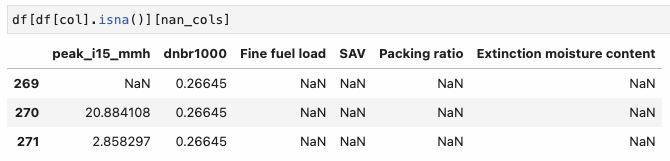

In [70]:
# picking easiest one to type :)
# any of the other three would be fine
df = df.dropna(subset=['SAV'])
df.shape

(1376, 25)

In [72]:
nan_count = pd.DataFrame(df.isna().sum(), columns=['count'])
nan_count = nan_count[nan_count['count'] > 0]

nan_cols = list(nan_count.index)

nan_count

,count
peak_i15_mmh,109
dnbr1000,77


In [81]:
idx = 1
col = nan_cols[idx]
print(col)

# to get summary of nan count
#df[df[col].isna()].isna().sum()

# to view the df
df[df[col].isna()]#['response'].value_counts()

dnbr1000


,SiteID,fire_id,fire_name,fire_segid,year,state,response,stormdate,gaugedist_m,lat,...,dnbr1000,kf,Fine fuel load,SAV,Packing ratio,Extinction moisture content,LNDS_RISKS,fire_interval,SedUn,SuscFrac
42,37,can,Canyon,can_178,2007,CA,0,22,1685.96,34.058303,...,NaN,0.210000,1.460550,1727.041284,0.010079,18.853211,96.305814,1.0,1.0,0.977064
51,46,can,Canyon,can_558,2007,CA,0,22,1127.42,34.037234,...,NaN,0.210000,1.372025,1834.153075,0.003318,15.240642,96.305814,1.0,1.0,0.662182
468,257,h2f,Horseshoe 2,h2f_10214,2001,AZ,0,11,3729.34,31.937136,...,NaN,0.387281,3.131857,1639.596448,0.028991,26.797437,76.774815,10.0,0.0,1.000000
469,257,h2f,Horseshoe 2,h2f_10214,2001,AZ,0,11,3729.34,31.937136,...,NaN,0.387281,3.131857,1639.596448,0.028991,26.797437,76.774815,10.0,0.0,1.000000
470,257,h2f,Horseshoe 2,h2f_10214,2001,AZ,0,13,3729.34,31.937136,...,NaN,0.387281,3.131857,1639.596448,0.028991,26.797437,76.774815,10.0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,395,scz,Schultz,scz_792,2010,AZ,1,20,2238.05,35.348953,...,NaN,0.337403,1.564575,1792.639022,0.004912,16.353771,97.462255,0.0,0.0,0.225601
806,395,scz,Schultz,scz_792,2010,AZ,0,22,2238.05,35.348953,...,NaN,0.337403,1.564575,1792.639022,0.004912,16.353771,97.462255,0.0,0.0,0.225601
807,395,scz,Schultz,scz_792,2010,AZ,0,27,2238.05,35.348953,...,NaN,0.337403,1.564575,1792.639022,0.004912,16.353771,97.462255,0.0,0.0,0.225601
808,395,scz,Schultz,scz_792,2010,AZ,0,1,2238.05,35.348953,...,NaN,0.337403,1.564575,1792.639022,0.004912,16.353771,97.462255,0.0,0.0,0.225601


In [90]:
temp = df[df['dnbr1000'].isna()]
print("n_sites: ", temp['SiteID'].nunique())
temp.groupby(['SiteID'])['response'].value_counts().unstack().fillna(0).astype(int)

n_sites:  18


response,0,1
SiteID,,
37,1,0
46,1,0
257,4,0
258,4,0
259,3,1
260,4,0
261,3,1
262,3,1
263,5,1


In [129]:
temp.groupby(['state'])['response'].value_counts(normalize=True).unstack().fillna(0)#.astype(int)

response,0,1
state,,
AZ,0.76,0.24
CA,1.00,0.00


In [130]:
df.groupby(['state'])['response'].value_counts(normalize=True).unstack().fillna(0)#.astype(int)

response,0,1
state,,
AZ,0.803828,0.196172
CA,0.759901,0.240099
CO,0.882155,0.117845
NM,0.396552,0.603448
UT,0.000000,1.000000


In [138]:
df[df['state'] == 'UT'][['lat', 'lon']]

,lat,lon
617,39.981119,-111.760945
618,39.976136,-111.761739
619,39.966260,-111.756419
620,39.956666,-111.759679


**dnbr1000**: *Average differenced normalized burn ratio (dNBR) of watershed, divided by 1000*

- it may make sense to fill these values with zer0
- they could be na simply because the number is actually zero

In [94]:
df['dnbr1000'].describe()

count    1299.000000
mean        0.343840
std         0.192645
min         0.007158
25%         0.191424
50%         0.324197
75%         0.465832
max         0.997439
Name: dnbr1000, dtype: float64

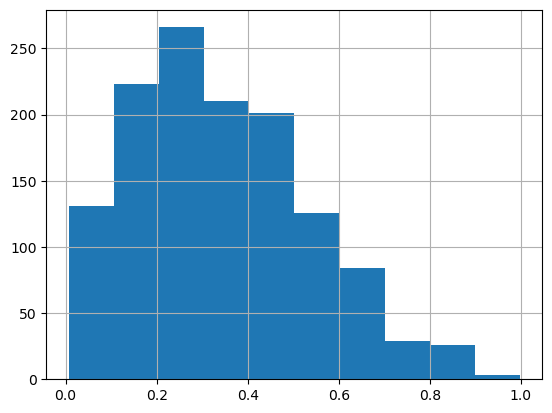

In [93]:
df['dnbr1000'].hist();

In [98]:
df.groupby(['response'])['dnbr1000'].describe().T

response,0,1
count,1008.000000,291.000000
mean,0.338458,0.362481
std,0.199042,0.167604
min,0.007158,0.039175
25%,0.184352,0.222363
50%,0.308938,0.362239
75%,0.461608,0.483315
max,0.997439,0.867421


In [99]:
import seaborn as sns

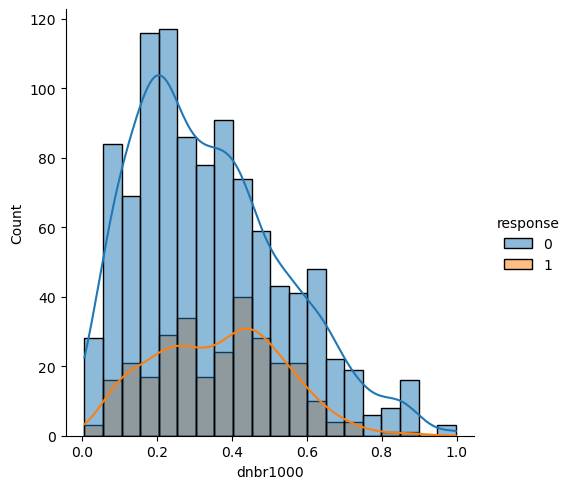

In [112]:
sns.displot(data=df, x='dnbr1000', hue='response', kde='True')

**fill na or drop**

- CHOOSING FILL FOR NOW

In [182]:
# fill with zer0
df['dnbr1000'] = df['dnbr1000'].fillna(0)
df.shape

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


(1376, 25)

In [ ]:
# # drop the nulls
# df = df.dropna(subset=['dnbr1000'])
# df.shape

In [183]:
# expected behavior
# the above warning is not relevant here
df.isna().sum()

SiteID                           0
fire_id                          0
fire_name                        0
fire_segid                       0
year                             0
state                            0
response                         0
stormdate                        0
gaugedist_m                      0
lat                              0
lon                              0
geom                             0
peak_i15_mmh                   109
contributingarea_km2             0
prophm23                         0
dnbr1000                         0
kf                               0
Fine fuel load                   0
SAV                              0
Packing ratio                    0
Extinction moisture content      0
LNDS_RISKS                       0
fire_interval                    0
SedUn                            0
SuscFrac                         0
dtype: int64

**now the big one, rain!**

In [185]:
idx = 0
col = nan_cols[idx]
print(col)

# to get summary of nan count
#df[df[col].isna()].isna().sum()

# to view the df
df[df[col].isna()]['response'].value_counts()

peak_i15_mmh


0    109
Name: response, dtype: int64

In [186]:
# these should all be set to zer0
df['peak_i15_mmh'] = df['peak_i15_mmh'].fillna(0)
df.shape

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


(1376, 25)

In [187]:
df.isna().sum()

SiteID                         0
fire_id                        0
fire_name                      0
fire_segid                     0
year                           0
state                          0
response                       0
stormdate                      0
gaugedist_m                    0
lat                            0
lon                            0
geom                           0
peak_i15_mmh                   0
contributingarea_km2           0
prophm23                       0
dnbr1000                       0
kf                             0
Fine fuel load                 0
SAV                            0
Packing ratio                  0
Extinction moisture content    0
LNDS_RISKS                     0
fire_interval                  0
SedUn                          0
SuscFrac                       0
dtype: int64

**KF**: *Average KF-Factor (erodibility index of the fine fragments of the soil) of the watershed*

there are a couple outlandish values, should filter them

In [145]:
df['kf'].describe()

count    1376.000000
mean        0.236937
std         0.453519
min         0.000000
25%         0.160000
50%         0.239645
75%         0.264733
max        11.360418
Name: kf, dtype: float64

In [152]:
df['kf'].describe()

count    1376.000000
mean        0.236937
std         0.453519
min         0.000000
25%         0.160000
50%         0.239645
75%         0.264733
max        11.360418
Name: kf, dtype: float64

In [172]:
# you can see these values are waaaaay above the rest of the data (outliers)
df[df['kf'] > .39]#.shape

,SiteID,fire_id,fire_name,fire_segid,year,state,response,stormdate,gaugedist_m,lat,...,dnbr1000,kf,Fine fuel load,SAV,Packing ratio,Extinction moisture content,LNDS_RISKS,fire_interval,SedUn,SuscFrac
64,59,cg,Cerro Grande,cg_2811,2000,NM,0,16,576.986342,35.905976,...,0.866541,0.979461,2.639095,1708.904303,0.003062,15.469214,16.672021,0.0,0.000000,0.622404
476,259,h2f,Horseshoe 2,h2f_10458,2001,AZ,1,11,2343.790000,31.931246,...,NaN,0.733884,3.180081,1650.892897,0.024110,24.085029,76.774815,10.0,0.003091,0.971578
477,259,h2f,Horseshoe 2,h2f_10458,2001,AZ,0,11,2343.790000,31.931246,...,NaN,0.733884,3.180081,1650.892897,0.024110,24.085029,76.774815,10.0,0.003091,0.971578
478,259,h2f,Horseshoe 2,h2f_10458,2001,AZ,0,13,2343.790000,31.931246,...,NaN,0.733884,3.180081,1650.892897,0.024110,24.085029,76.774815,10.0,0.003091,0.971578
479,259,h2f,Horseshoe 2,h2f_10458,2001,AZ,0,15,2343.790000,31.931246,...,NaN,0.733884,3.180081,1650.892897,0.024110,24.085029,76.774815,10.0,0.003091,0.971578
571,295,lb,Little Bear,lb_1869,2012,NM,1,10,637.514953,33.457880,...,0.258807,3.547535,6.021280,1434.442907,0.024328,26.756055,54.706071,1.0,0.000000,0.986348
572,295,lb,Little Bear,lb_1869,2012,NM,1,23,637.514953,33.457880,...,0.258807,3.547535,6.021280,1434.442907,0.024328,26.756055,54.706071,1.0,0.000000,0.986348
575,297,lb,Little Bear,lb_1930,2012,NM,1,10,1401.780000,33.457195,...,0.361525,0.536829,4.148664,1791.450070,0.023591,26.336146,54.706071,1.0,0.000000,1.000000
576,297,lb,Little Bear,lb_1930,2012,NM,1,23,1401.780000,33.457195,...,0.361525,0.536829,4.148664,1791.450070,0.023591,26.336146,54.706071,1.0,0.000000,1.000000
583,301,lb,Little Bear,lb_2076,2012,NM,1,10,1037.460000,33.454449,...,0.508008,11.360418,4.232764,1517.885968,0.019444,23.918078,54.706071,1.0,0.000000,0.917497


In [175]:
df[df['kf'] > .39]['response'].value_counts()

1    7
0    4
Name: response, dtype: int64

**save the file**

In [190]:
# final step, reset index, just good practice
df = df.reset_index(drop=True)
df.shape

(1376, 25)

In [191]:
# one last check
df.isna().sum()

SiteID                         0
fire_id                        0
fire_name                      0
fire_segid                     0
year                           0
state                          0
response                       0
stormdate                      0
gaugedist_m                    0
lat                            0
lon                            0
geom                           0
peak_i15_mmh                   0
contributingarea_km2           0
prophm23                       0
dnbr1000                       0
kf                             0
Fine fuel load                 0
SAV                            0
Packing ratio                  0
Extinction moisture content    0
LNDS_RISKS                     0
fire_interval                  0
SedUn                          0
SuscFrac                       0
dtype: int64

In [192]:
# now write out the final data file
df.to_parquet("../../data/data_v09_consolidated.parquet")

## Train-Test Split <a id="split">

Data rows are split by SiteID, such that observations made at same site (during different storms) are not assigned to the both the test and training set.
The `unique` attribute is, therefore, essential - otherwise the split of train and test data by site is not guaranteed.

In [10]:
train_sites, test_sites = train_test_split(df['SiteID'].unique(), test_size=0.20, shuffle=True, random_state=seed)

In [11]:
# no overlap
set(train_sites).intersection(set(test_sites))

set()

In [12]:
# how to retain the non-feature/response cols
# could join back in later? think through this

train_mask = df['SiteID'].isin(train_sites)
test_mask = df['SiteID'].isin(test_sites)

In [13]:
X_train = df.loc[train_mask, feature_cols]
X_test = df.loc[test_mask, feature_cols]

y_train = df.loc[train_mask, 'response']
y_test = df.loc[test_mask, 'response']

In [14]:
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("\n")
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (863, 13)
X_test:  (215, 13)


y_train:  (863,)
y_test:  (215,)


In [15]:
pickle.dump([X_train, X_test, y_train, y_test], open("../../data/train_test_data.pkl", "wb"))

## Model Parameters <a id="json">
    
create an json file that we will add to in model tuning steps
    - check if it already exists first so we don't overwrite
    - if it doesn't already exists, this will create an empty file which subsequent notebooks will use

In [26]:
import os
import json

In [27]:
file_path = "../../model/model_parameters.json"
if os.path.isfile(file_path) == True:
    print("parameter json already exists")
else:
    print("created empty json file")
    model_params = {} # create empty dict
    with open(file_path, "w") as json_file:
        json.dump(model_params, json_file)

created empty json file
